In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
import MySQLdb as mdb
# from definitions import DATABASE_CONFIG_DIR, INCOME_STATEMENT_DIR

## load stock info

In [4]:
with open('../../database/database_config/database.ymal') as f:
    db_config = yaml.load(f, Loader=yaml.FullLoader)
db = mdb.connect(host=db_config['db_host'], user=db_config['db_user'], passwd=db_config['db_pass'],
                 db=db_config['db_name'], use_unicode=True, charset="utf8")
# select stockId and ticker from table stock_info
table_name = 'stock_info'
column_list = ['stockId', 'ticker', 'IndustryGroup']
columns = ','.join(column_list)
req = """SELECT %s FROM %s WHERE sp500=TRUE """ % (columns, table_name)
get_stock_info_cursor = db.cursor()
get_stock_info_cursor.execute(req)
stock_info = get_stock_info_cursor.fetchall()
get_stock_info_cursor.close()

#create dataframe
df_stock_info = pd.DataFrame(stock_info, columns=column_list)

In [5]:
df_stock_info.head(5)

,stockId,ticker,IndustryGroup
0,11,PNR,Machinery
1,37,ALLE,Building Materials
2,45,ITW,Machinery
3,48,AMAT,Semiconductor Equip
4,52,NWL,Household Products


## load the file

In [6]:
file = '../20210809_valuation_result_sp500.csv'
df_valuation = pd.read_csv(file)

In [7]:
df_valuation.head(5)

,ticker,current_price,estimated_value,price_to_value
0,PNR,77.10,37.643159,2.048181
1,ALLE,137.54,87.640388,1.569368
2,ITW,227.73,91.887108,2.478367
3,AMAT,142.65,91.670900,1.556110
4,NWL,25.46,9.927893,2.564492


In [8]:
df_valuation.describe()

,current_price,estimated_value,price_to_value
count,462.000000,460.000000,460.000000
mean,190.774654,72.491775,1.293950
std,345.102401,342.856429,27.870813
min,11.750000,-356.345811,-435.074636
25%,59.937500,0.824544,0.064209
50%,115.290000,31.617656,1.784827
75%,211.040000,82.240074,4.010162
max,5212.950000,6221.015793,249.727749


## merge two dataframes

In [9]:
df = pd.merge(df_valuation, df_stock_info, left_on='ticker', right_on='ticker', how='left')

In [10]:
## filter out finanace sector 
df = df.loc[(df['IndustryGroup']!='Financial Svcs. (Non-bank & Insurance)')
                 & (df['IndustryGroup']!='Banks (Regional)') 
                 & (df['IndustryGroup']!='Bank (Money Center)') 
                 & (df['IndustryGroup']!='Brokerage & Investment Banking') 
                 & (df['IndustryGroup']!='Investments & Asset Management') 
                 & (df['IndustryGroup']!='Insurance (Life)')
                 & (df['IndustryGroup']!='Insurance (Prop/Cas.)')
                 & (df['IndustryGroup']!='Insurance (General)')]

## EDA

array([[<AxesSubplot:title={'center':'price_to_value'}>]], dtype=object)

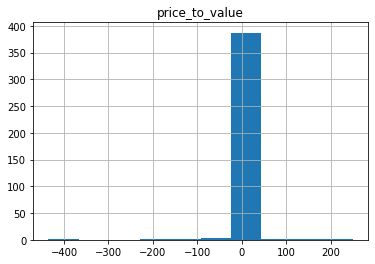

In [11]:
df.hist(column="price_to_value")

### calculate the range

In [12]:
def cut_to(x):
    if x<0:
        return 'less than 0'
    elif x<1:
        return '0-1'
    else:
        return 'larger than 1'

df['valuation_range'] = df['price_to_value'].map(cut_to)

In [13]:
df

,ticker,current_price,estimated_value,price_to_value,stockId,IndustryGroup,valuation_range
0,PNR,77.10,37.643159,2.048181,11,Machinery,larger than 1
1,ALLE,137.54,87.640388,1.569368,37,Building Materials,larger than 1
2,ITW,227.73,91.887108,2.478367,45,Machinery,larger than 1
3,AMAT,142.65,91.670900,1.556110,48,Semiconductor Equip,larger than 1
4,NWL,25.46,9.927893,2.564492,52,Household Products,larger than 1
...,...,...,...,...,...,...,...
500,UAL,47.62,-56.970543,-0.835871,9772,Air Transport,less than 0
501,CDW,190.05,40.391222,4.705230,9829,Computer Services,larger than 1
502,MU,82.00,123.149675,0.665856,9839,Semiconductor,0-1
503,DLTR,98.77,52.678832,1.874947,9850,Retail (General),larger than 1


In [14]:
df['valuation_range'].value_counts()

larger than 1    310
less than 0      109
0-1               24
Name: valuation_range, dtype: int64

## sort

In [15]:
df.sort_values(by=['price_to_value'])

,ticker,current_price,estimated_value,price_to_value,stockId,IndustryGroup,valuation_range
477,TFX,380.88,-0.875436,-435.074636,9391,Healthcare Products,less than 0
5,MAA,191.07,-1.065426,-179.336777,54,R.E.I.T.,less than 0
307,BIO,753.63,-7.346978,-102.576869,5711,Heathcare Information and Technology,less than 0
78,NI,25.40,-0.271815,-93.446027,1509,Utility (General),less than 0
169,ZBH,149.00,-2.434665,-61.199393,3210,Healthcare Products,less than 0
...,...,...,...,...,...,...,...
401,GOOGL,NaN,NaN,NaN,7514,empty,larger than 1
402,LW,NaN,NaN,NaN,7517,Food Processing,larger than 1
415,MXIM,NaN,NaN,NaN,7952,Semiconductor,larger than 1
456,CBOE,NaN,NaN,NaN,8855,empty,larger than 1


### select the valuation between 0-1

In [16]:
df = df.loc[df['valuation_range'] == '0-1']
df = df.sort_values(by=['price_to_value'])

array([[<AxesSubplot:title={'center':'price_to_value'}>]], dtype=object)

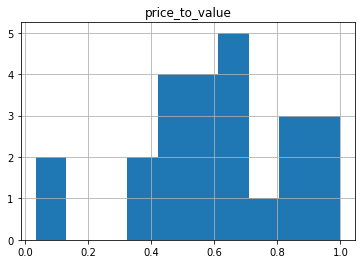

In [17]:
df.hist(column="price_to_value")

In [18]:
df.head(10)

,ticker,current_price,estimated_value,price_to_value,stockId,IndustryGroup,valuation_range
23,CI,209.30,6221.015793,0.033644,344,Healthcare Support Services,0-1
479,DXC,41.09,552.309101,0.074397,9425,Computer Services,0-1
96,FANG,80.05,240.945501,0.332233,1764,Oil/Gas (Production and Exploration),0-1
26,CNC,66.80,174.584305,0.382623,375,Healthcare Support Services,0-1
133,TSN,71.12,163.072354,0.436125,2473,Food Processing,0-1
356,WBA,47.10,98.038753,0.480422,6569,Retail (Special Lines),0-1
53,PHM,52.95,106.503215,0.497168,1120,Homebuilding,0-1
140,ABC,120.64,236.278563,0.510584,2669,Healthcare Support Services,0-1
194,LEN,104.05,197.275010,0.527436,3614,Homebuilding,0-1
362,DHI,94.70,179.225511,0.528385,6698,Homebuilding,0-1


In [19]:
df.loc[(df['price_to_value']>0.1) & (df['price_to_value']<0.8)]

,ticker,current_price,estimated_value,price_to_value,stockId,IndustryGroup,valuation_range
96,FANG,80.05,240.945501,0.332233,1764,Oil/Gas (Production and Exploration),0-1
26,CNC,66.80,174.584305,0.382623,375,Healthcare Support Services,0-1
133,TSN,71.12,163.072354,0.436125,2473,Food Processing,0-1
356,WBA,47.10,98.038753,0.480422,6569,Retail (Special Lines),0-1
53,PHM,52.95,106.503215,0.497168,1120,Homebuilding,0-1
140,ABC,120.64,236.278563,0.510584,2669,Healthcare Support Services,0-1
194,LEN,104.05,197.275010,0.527436,3614,Homebuilding,0-1
362,DHI,94.70,179.225511,0.528385,6698,Homebuilding,0-1
35,HII,205.58,382.572232,0.537363,680,Aerospace/Defense,0-1
97,HPQ,29.32,52.408186,0.559455,1784,Computers/Peripherals,0-1
